Ordered corners (x, y):
[[ 44.  40.]
 [193.  19.]
 [223. 227.]
 [ 75. 249.]]


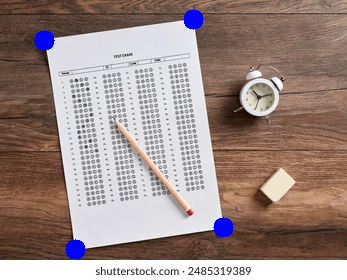

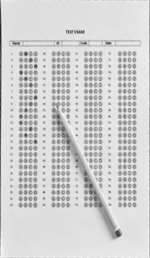

In [80]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/top-view-test-exam-paper-260nw-2485319389.webp")
orig = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

paper_contour = None
max_area = 0
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    area = cv2.contourArea(cnt)
    if len(approx) == 4 and area > max_area:
        paper_contour = approx
        max_area = area

if paper_contour is not None:
    corners = paper_contour.reshape(4, 2)
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    ordered_corners = order_points(corners)
    for pt in ordered_corners:
        cv2.circle(orig, tuple(pt.astype(int)), 10, (255, 0, 0), -1)

    print("Ordered corners (x, y):")
    print(ordered_corners)
    pts1 = np.float32 ([ordered_corners[0], ordered_corners[1], ordered_corners[2], ordered_corners[3]])
    width_top = np.linalg.norm(ordered_corners[0] - ordered_corners[1])
    width_bottom = np.linalg.norm(ordered_corners[2] - ordered_corners[3])
    max_width = int(max(width_top, width_bottom))
    height_left = np.linalg.norm(ordered_corners[0] - ordered_corners[2])
    height_right = np.linalg.norm(ordered_corners[1] - ordered_corners[3])
    max_height = int(max(height_left, height_right))

    pts2 = np.float32([
    [0, 0],
    [max_width - 1, 0],
    [max_width - 1, max_height - 1],
    [0, max_height - 1]
    ])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(gray, matrix, (max_width, max_height))
    cv2_imshow(orig)
    cv2_imshow(result)


